In [22]:
# importing of libaries
import numpy as np                      #functions for scientific computing, faster arrays
import pandas as pd                     #easy import and export of data, fast and easy-to-use datastructure
import math                             #mathematical functions
import matplotlib.pyplot as plt         #generation of Graphs
import seaborn as sns                   #generation of Graphs
from scipy.constants import pi, g       #fundamental Constants
import Leistung as lei                  #Eigenes Modul um Leistung und Fahrtwiderstaende zu berechnen                        

In [23]:
# document paths
path_data_drive1 = "data/long1.csv"

# Read all the data
data_drive1 = pd.read_csv(path_data_drive1)
data_drive1

,Index (),ENGINE_RUN_TINE (),ENGINE_RPM (),VEHICLE_SPEED (),THROTTLE (),ENGINE_LOAD (),COOLANT_TEMPERATURE (),LONG_TERM_FUEL_TRIM_BANK_1 (),SHORT_TERM_FUEL_TRIM_BANK_1 (),INTAKE_MANIFOLD_PRESSURE (),...,INTAKE_AIR_TEMP (),TIMING_ADVANCE (),CATALYST_TEMPERATURE_BANK1_SENSOR1 (),CATALYST_TEMPERATURE_BANK1_SENSOR2 (),CONTROL_MODULE_VOLTAGE (),COMMANDED_EVAPORATIVE_PURGE (),TIME_RUN_WITH_MIL_ON (),TIME_SINCE_TROUBLE_CODES_CLEARED (),DISTANCE_TRAVELED_WITH_MIL_ON (),WARM_UPS_SINCE_CODES_CLEARED ()
0,0.0,0,0.00,0,17.647058,0.000000,80,-4.6875,0.00000,101,...,48,5,498.299988,361.500000,12.500,0.000000,0,8420,0,255
1,0.0,0,0.00,0,17.647058,0.000000,80,-4.6875,0.00000,101,...,48,5,498.299988,361.500000,12.500,0.000000,0,8420,0,255
2,0.0,0,0.00,0,17.647058,0.000000,80,-4.6875,0.00000,101,...,48,5,498.299988,361.500000,12.500,0.000000,0,8420,0,255
3,0.0,0,0.00,0,17.647058,0.000000,80,-4.6875,0.00000,101,...,48,5,498.299988,361.500000,12.500,0.000000,0,8420,0,255
4,0.0,0,253.75,0,17.254902,0.000000,80,-4.6875,0.00000,89,...,48,5,498.299988,361.500000,12.500,0.000000,0,8420,0,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3523,NaN,1731,715.50,0,15.686275,24.313726,88,-1.5625,0.78125,26,...,48,0,452.700012,341.799988,13.789,23.921568,0,8448,0,255
3524,NaN,1731,719.50,0,15.686275,24.313726,88,-1.5625,5.46875,26,...,48,-2,452.700012,341.799988,13.789,23.921568,0,8448,0,255
3525,NaN,1733,719.50,0,15.686275,24.313726,88,-1.5625,5.46875,26,...,48,-2,452.700012,341.799988,13.789,23.921568,0,8448,0,255
3526,NaN,1733,719.50,0,15.686275,24.313726,88,-1.5625,5.46875,26,...,48,-2,451.500000,341.000000,13.789,23.921568,0,8448,0,255


In [24]:
# Constants
d_wheel = .583 #m Reifendurchmesser
#Source: https://tirewheelguide.de/sizes/toyota/etios-liva/2014/

In [25]:
# Wheel rotation from speed
# pV: speed in m/s
# 100: konversion cm to m
def n_Rad(pV):
    return (pV) / (d_wheel * pi)

In [26]:
data_drive1 = data_drive1.assign(N_RAD = data_drive1['VEHICLE_SPEED ()'].apply(n_Rad))

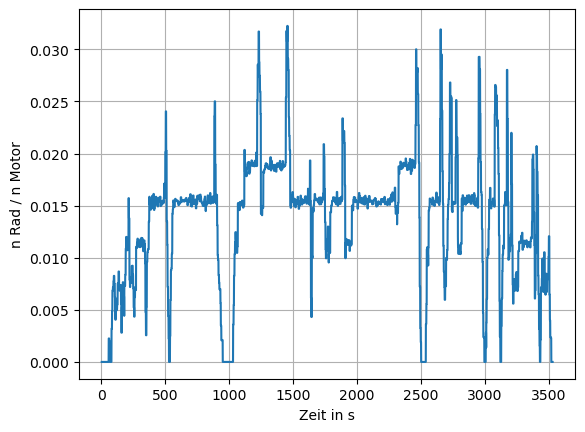

In [27]:
length = int(data_drive1.shape[0])
div = np.zeros(length)
div = data_drive1["N_RAD"]/data_drive1["ENGINE_RPM ()"]

plt.plot(div)
plt.xlabel("Zeit in s")
plt.ylabel("n Rad / n Motor")
plt.savefig("div.png")
plt.grid(True)
plt.show()

weiteres vorgehen für die Bestimmung der Gänge, bereiche in denen sich die Drehzahl länger aufhält finden und für den x bereich den Durchschnitt bilden

In [28]:
data_drive1

,Index (),ENGINE_RUN_TINE (),ENGINE_RPM (),VEHICLE_SPEED (),THROTTLE (),ENGINE_LOAD (),COOLANT_TEMPERATURE (),LONG_TERM_FUEL_TRIM_BANK_1 (),SHORT_TERM_FUEL_TRIM_BANK_1 (),INTAKE_MANIFOLD_PRESSURE (),...,TIMING_ADVANCE (),CATALYST_TEMPERATURE_BANK1_SENSOR1 (),CATALYST_TEMPERATURE_BANK1_SENSOR2 (),CONTROL_MODULE_VOLTAGE (),COMMANDED_EVAPORATIVE_PURGE (),TIME_RUN_WITH_MIL_ON (),TIME_SINCE_TROUBLE_CODES_CLEARED (),DISTANCE_TRAVELED_WITH_MIL_ON (),WARM_UPS_SINCE_CODES_CLEARED (),N_RAD
0,0.0,0,0.00,0,17.647058,0.000000,80,-4.6875,0.00000,101,...,5,498.299988,361.500000,12.500,0.000000,0,8420,0,255,0.0
1,0.0,0,0.00,0,17.647058,0.000000,80,-4.6875,0.00000,101,...,5,498.299988,361.500000,12.500,0.000000,0,8420,0,255,0.0
2,0.0,0,0.00,0,17.647058,0.000000,80,-4.6875,0.00000,101,...,5,498.299988,361.500000,12.500,0.000000,0,8420,0,255,0.0
3,0.0,0,0.00,0,17.647058,0.000000,80,-4.6875,0.00000,101,...,5,498.299988,361.500000,12.500,0.000000,0,8420,0,255,0.0
4,0.0,0,253.75,0,17.254902,0.000000,80,-4.6875,0.00000,89,...,5,498.299988,361.500000,12.500,0.000000,0,8420,0,255,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3523,NaN,1731,715.50,0,15.686275,24.313726,88,-1.5625,0.78125,26,...,0,452.700012,341.799988,13.789,23.921568,0,8448,0,255,0.0
3524,NaN,1731,719.50,0,15.686275,24.313726,88,-1.5625,5.46875,26,...,-2,452.700012,341.799988,13.789,23.921568,0,8448,0,255,0.0
3525,NaN,1733,719.50,0,15.686275,24.313726,88,-1.5625,5.46875,26,...,-2,452.700012,341.799988,13.789,23.921568,0,8448,0,255,0.0
3526,NaN,1733,719.50,0,15.686275,24.313726,88,-1.5625,5.46875,26,...,-2,451.500000,341.000000,13.789,23.921568,0,8448,0,255,0.0
